# CNN
This notebook contains a test CNN in pytorch, to get familiar with this developping environment. It also acts as a template for later use.

In [37]:
%matplotlib inline
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import os,sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import time

#seed for reproducible results
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [38]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

## Pytorch module

This module contains the CNN named SimpleCNN.

In "init", the layers have to be initialized (for instance conv layers, maxpool layers and fully connected layers. ReLu do not take hyperparameters, so it doesn't need an initialization.

In "forward", the structure of the CNN is laid out by taking an input tensor x and applying the layers in the correct order to this tensor. This function is the forward pass of the CNN and returns the computed x.

The backward pass can be computed by Pytorch's autograd function. For this to be achieved, our input tensor and our weights must be of type "Variable" (as imported above), this type stores changes to the tensor automatically which makes it possible to compute the gradient very easily. When declaring a Variable tensor, the option "requires_grad" must be set to True, otherwise the gradient will not be computed.

### Module structure

For this example module, we will define a fully convolutional neural network (FCN), with three convolutional layers and one transposed convolution (or deconvolution) to upsample the results of the convolutions.


- Input image: 3 channels 400x400

Three convolutions layers so that spatial stuff happen (every parameter is pretty arbitrary right now)
- Convolution with kernel size 5, reduce to 1 channel (output  1 channel 396x396)
- ReLu
- MaxPool with kernel size 2 (output 198x198)
- Convolution with kernel size 17 (output 182x182)
- ReLu
- MaxPool with kernel size 2 (output 91x91)
- Convolution with kernel size 22 (output 70x70)
- ReLu
- MaxPool with kernel size 2 (output 35x35)

A transposed convolution layer
- Deconv with kernel size 400-35+1=366 (output 400x400)
- Sigmoid for the binary classification

In [3]:
class FCN_3conv_1deconv(torch.nn.Module):
        
    def __init__(self):
        super(FCN_3conv_1deconv, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv2d(1, 1, kernel_size=17)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = torch.nn.Conv2d(1, 1, kernel_size=22)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.deconv = torch.nn.ConvTranspose2d(1, 2, kernel_size=366)
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = self.deconv(x)
        x = self.sigmoid(x)
        
        return(x)

This model optimized with adam and cross entropy will converge to all-black images every time

## Training the model

In [4]:
# Loading a set of 100 training images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = np.array([load_image(image_dir + files[i]) for i in range(n)]).swapaxes(1,3).swapaxes(2,3)
print(np.shape(imgs))

train_input = imgs[0:15] #norm = 0:90
validation_input = imgs[15:20] #norm = 90:100

image_dir = root_dir + "groundtruth/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(np.shape(imgs))

train_target = imgs[0:15] #norm = 0:90
validation_target = imgs[15:20] #norm = 90:100

Loading 100 images
(100, 3, 400, 400)
Loading 100 images
(100, 400, 400)


We will keep 10 images from this set as a validation set

### Instantiate the model, loss function and optimizer

In [5]:
# We will optimize the cross-entropy loss using adam algorithm
net = FCN_3conv_1deconv()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [32]:
def trainNet(net, n_epochs):
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            
            input_image = Variable(torch.tensor(train_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(train_target[index], dtype=torch.long).unsqueeze(0))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(input_image)
            loss = loss_function(outputs, target_image)
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item()
            
            print("Epoch", epoch, ", image", index, ", image loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            
            input_image = Variable(torch.tensor(validation_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(validation_target[index], dtype=torch.long).unsqueeze(0))
            
            #Forward pass
            val_outputs = net(input_image)
            val_loss = loss_function(val_outputs, target_image)
            total_val_loss += val_loss.item()
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [9]:
trainNet(net, 3)

torch.Size([1, 2, 400, 400])

torch.Size([1, 400, 400])

Epoch 0 , image 0 , image loss: 0.693555474281311 , time elapsed: 3.7940659523010254


torch.Size([1, 2, 400, 400])

torch.Size([1, 400, 400])

Epoch 0 , image 1 , image loss: 0.6881590485572815 , time elapsed: 6.554765462875366


torch.Size([1, 2, 400, 400])

torch.Size([1, 400, 400])

Epoch 0 , image 2 , image loss: 0.679782509803772 , time elapsed: 9.274024724960327


torch.Size([1, 2, 400, 400])

torch.Size([1, 400, 400])

Epoch 0 , image 3 , image loss: 0.6683339476585388 , time elapsed: 11.993794441223145


torch.Size([1, 2, 400, 400])

torch.Size([1, 400, 400])

KeyboardInterrupt: 

In [ ]:
input_image = torch.tensor(validation_input[0]).unsqueeze(0)
target_image = torch.tensor(validation_target[0]).unsqueeze(0)
           
#Forward pass
val_output = net(input_image)
output_image = val_output[0,1]

In [ ]:
plt.imshow(target_image.squeeze(0), cmap='Greys_r')

In [ ]:
plt.imshow(output_image.detach().numpy(), cmap='Greys_r')

# Birth of the new model: balanced-dataset-compliant model
The previously presented model is not truly fully convolutional, because the last layer of deconvolution is hardcoded to render a 400x400 output image. We would like to output a NxN image where NxN is also the size of the input. This is absolutely necessary to train a model using the balanced dataset since the balanced dataset is made of 100x100 and 200x200 images and will have to be tested on 400x400 images. We will fix the deconvolution layer and have convolutional layers that do not reduce the input as much because otherwise it would reject 100x100 images. Here we go!

In [39]:
class FCN_3conv_1deconv_balanced(torch.nn.Module):
        
    def __init__(self):
        super(FCN_3conv_1deconv_balanced, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = torch.nn.Conv2d(1, 1, kernel_size=7)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = torch.nn.Conv2d(1, 1, kernel_size=12)
        
        self.deconv = torch.nn.ConvTranspose2d(1, 2, kernel_size=16)
        self.upsample = torch.nn.UpsamplingBilinear2d(scale_factor=4)
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        
        x = self.deconv(x)
        x = self.upsample(x)
        x = self.sigmoid(x)
        
        return(x)

## Training the model
As a first try, we will only train on the 100x100 images, and use some of the 100x100 images as validation set

In [40]:
sat_images_100 = np.load('balanced_dataset/sat_images_100.npy').astype(np.float64).swapaxes(1,3).swapaxes(2,3) #1752 images
gt_images_100 = np.load('balanced_dataset/groundtruth_100.npy').astype(np.float64)

# We will take 1500 images as input, and the remaining 252 images as validation set
train_input = sat_images_100[:1500]
validation_input = sat_images_100[1500:]

train_target = gt_images_100[:1500]
validation_target = gt_images_100[1500:]

In [41]:
# We will optimize the cross-entropy loss using adam algorithm
net = FCN_3conv_1deconv_balanced()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [54]:
def trainNet(net, n_epochs):
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    for epoch in range(n_epochs):
        
        total_loss = 0.0
        
        for index in range(np.shape(train_input)[0]):
            
            input_image = Variable(torch.tensor(train_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(train_target[index], dtype=torch.long).unsqueeze(0))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            outputs = net(input_image.float())
            loss = loss_function(outputs, target_image)
            loss.backward()
            optimizer.step()
            
            #Print statistics
            total_loss += loss.item()
            
        print("Epoch", epoch, ", training loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)
            
        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
        for index in range(np.shape(validation_input)[0]):
            
            input_image = Variable(torch.tensor(validation_input[index], requires_grad=True).unsqueeze(0))
            target_image = Variable(torch.tensor(validation_target[index], dtype=torch.long).unsqueeze(0))
            
            #Forward pass
            val_outputs = net(input_image.float())
            val_loss = loss_function(val_outputs, target_image)
            total_val_loss += val_loss.item()
            
        print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

In [55]:
trainNet(net, 3)

Epoch 0 , training loss: 0.3132411241531372 , time elapsed: 10.793042182922363
Validation loss for epoch 0 : 0.3132411241531372
Epoch 1 , training loss: 0.3132389783859253 , time elapsed: 23.449750900268555
Validation loss for epoch 1 : 0.3132389783859253
Epoch 2 , training loss: 0.31323811411857605 , time elapsed: 36.61889147758484
Validation loss for epoch 2 : 0.31323811411857605
Training finished, took 37.51s


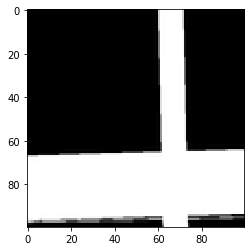

In [69]:
input_image = torch.tensor(validation_input[3]).unsqueeze(0)
target_image = torch.tensor(validation_target[3])
           
#Forward pass
val_output = net(input_image.float())
output_image = val_output[0,1]

plt.imshow(target_image, cmap='Greys_r')

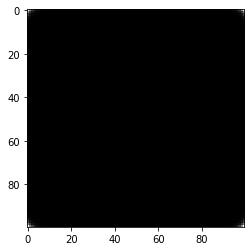

In [70]:
plt.imshow(output_image.detach().numpy(), cmap='Greys_r')

## Display the result

In [91]:
root_dir = "test_set_images/"
test_images=[]
for i in range(1, 51):
    image_filename = root_dir + "test_" + str(i) + "/test_" + str(i) + '.png'
    test_images.append(np.array(load_image(image_filename)).swapaxes(0,2).swapaxes(1,2))
    test_images
print(np.shape(test_images))

(50, 3, 608, 608)


In [129]:
crop = 100
masks = []
for test_image in test_images:
    _, im_height, im_width = np.shape(test_image)
    imgheight = test_image.shape[1]
    imgwidth = test_image.shape[2]
    mask = torch.zeros(1, imgheight, imgwidth)
    for i in range(0, imgheight, crop):
        for j in range(0, imgwidth, crop):
            # when the crop is bigger than the image size, we increase the temporary image with 0
            if(i+crop>imgheight and j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :imgwidth-j] = test_image[:, i:imgheight, j:imgwidth]
                im_patch = Variable(torch.tensor(im_patch, requires_grad=True).unsqueeze(0))
                mask[:, i:imgheight, j:imgwidth] = net(im_patch.float()).detach()[0,1,:imgheight-i,:imgwidth-j]
            
            elif(i+crop>imgheight):
                im_patch = np.zeros([3,crop,crop],dtype = np.float32)
                im_patch[:, :imgheight-i, :] = test_image[:, i:imgheight, j:j+crop]
                im_patch = Variable(torch.tensor(im_patch, requires_grad=True).unsqueeze(0))
                mask[:, i:imgheight, j:j+crop] = net(im_patch.float()).detach()[0,1,:imgheight-i,:]
            
            elif(j+crop>imgwidth):
                im_patch = np.zeros([3,crop,crop])
                im_patch[:, :, :imgwidth-j] = test_image[:, i:i+crop, j:imgwidth]
                im_patch = Variable(torch.tensor(im_patch, requires_grad=True).unsqueeze(0))
                mask[:, i:i+crop, j:imgwidth] = net(im_patch.float()).detach()[0,1,:,:imgwidth-j]
            
            else: # cas normal
                im_patch = test_image[:, i:i+crop, j:j+crop]
                im_patch = Variable(torch.tensor(im_patch, requires_grad=True).unsqueeze(0))
                mask[:, i:i+crop, j:j+crop] = net(im_patch).detach()[0,1,:,:]
    masks.append(mask.numpy())

In [149]:
import os
import numpy as np
import matplotlib.image as mpimg
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image, img_number):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[2], patch_size):
            patch = image[:,i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        i=int(0)
        for image in images[0:]:
            i+=1
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(image,i))


In [ ]:
submission_filename = 'submission.csv'
masks_to_submission(submission_filename, *masks)